In [154]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from itertools import combinations

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [155]:
df1 = pd.read_csv("Files/Customer Flight Activity_limpio.csv")
df1.sample()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
54143,319947,2017,4,1,0,1,2946,294.0,0,0


In [156]:
df = pd.read_csv("Files/datos_limpio_unidos.csv")
df.sample()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados,pais,provincia,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion,estado_cliente
75516,569236,2017,5,0,0,0,0,0.0,0,0,Canada,New Brunswick,Fredericton,E3B 2H2,Male,College,66937.5,Single,Star,2241.46,Standard,2013,9,9999,99,Activo


In [157]:
df1['ano'] = df1['ano'].astype(int)
df1['mes'] = df1['mes'].astype(int)
df1['dia'] = 1

# Crear la columna de fecha combinando año, mes y día
df1['fecha'] = pd.to_datetime(df1[['ano', 'mes', 'dia']].rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}))

# Verifica el resultado
print(df1[['ano', 'mes', 'dia', 'fecha']].head())

    ano  mes  dia      fecha
0  2017    1    1 2017-01-01
1  2017    1    1 2017-01-01
2  2017    1    1 2017-01-01
3  2017    1    1 2017-01-01
4  2017    1    1 2017-01-01


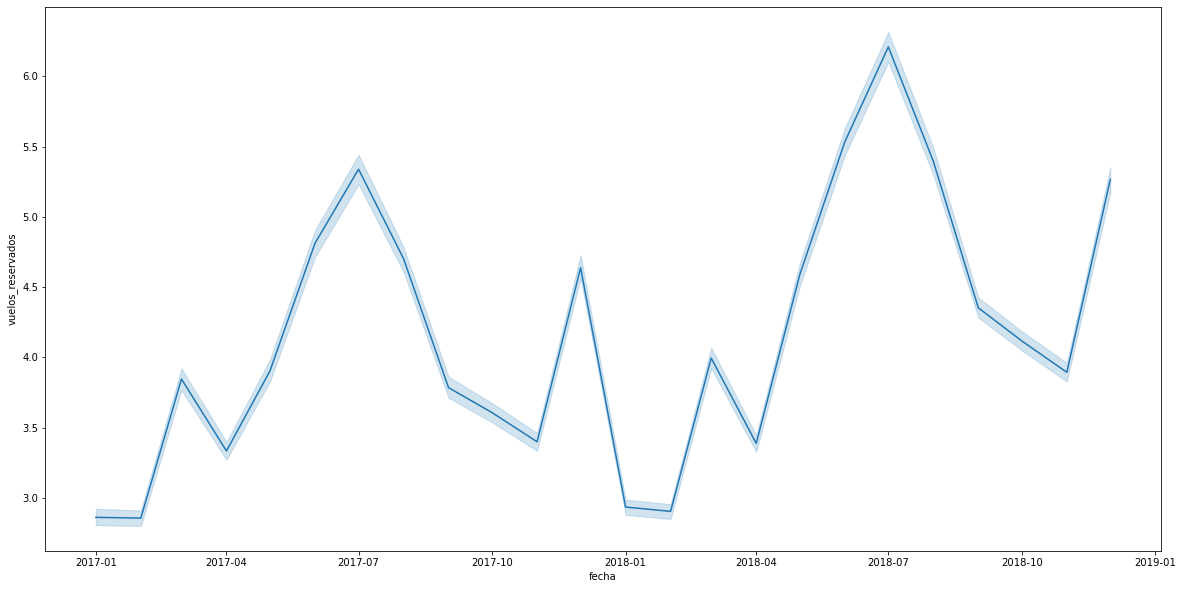

In [158]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df1, x="fecha", y="vuelos_reservados");

En esta gráfica vemos que los meses donde hay mas reservas en es verano y navidad. teniendo el pico mas alto (en ambos años) en julio. Vamos a ver como ha evolucionado esto de un año a otro en la siguiente gráfica

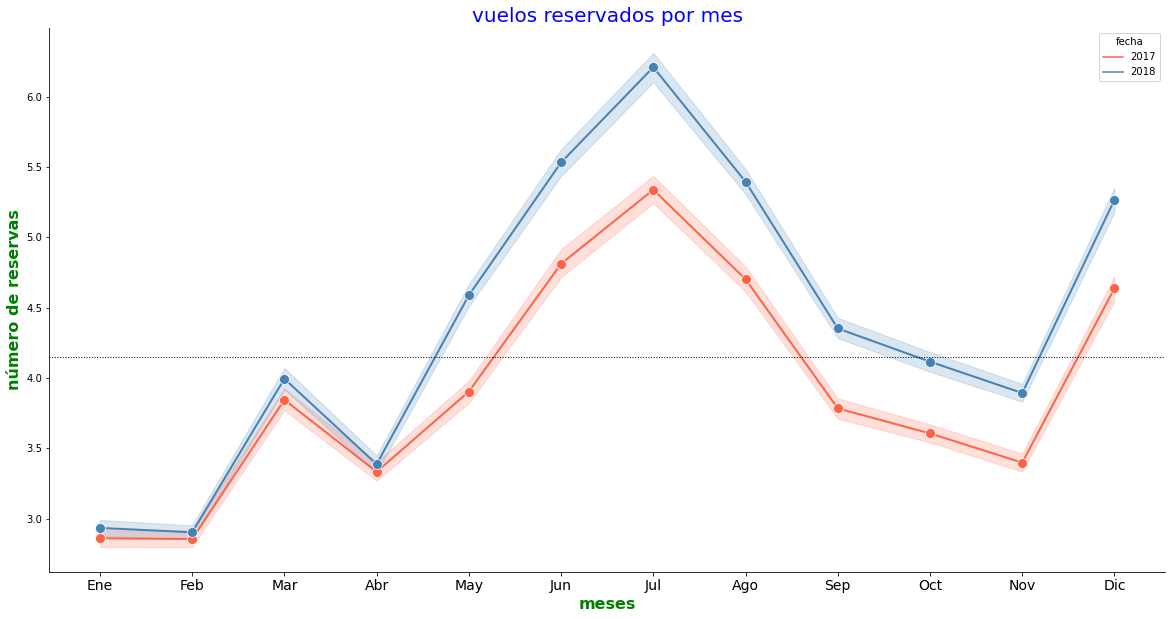

In [159]:
# hagamos un subplot con el vuelos_reservados y en función del mes

plt.subplots( figsize = (20, 10))

sns.lineplot(x=df1["fecha"].dt.month, y=df1["vuelos_reservados"],
            hue = df1["fecha"].dt.year,
            palette = ["#FF6347", "#4682B4"], # color de las lineas            
            marker = "o", # para especificar que marcador queremos
            markersize = 10, # para establecer el tamaño del marcador
            linewidth = 2 # para cambiar el grosor de la linea
            )

plt.title("vuelos reservados por mes",color = "blue", fontsize= 20)


# para cambiar las etiquetas del eje x y sus colores y tamaños
plt.xticks(np.sort(df1["fecha"].dt.month.unique()),  # valores originales del eje x
                ['Ene', "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], 
                color = "black", 
                fontsize = 14); # valores nuevos que queremos en el eje x

# para cambiar el nombre del eje x
plt.xlabel('meses', color = "green", fontweight = "bold", fontsize = 16)

# para cambiar el nobre el eje y
plt.ylabel('número de reservas', color = "green", fontweight = "bold", fontsize = 16)

# para quitar los ejes de arriba y de la derecha       
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


# para añadir una linea fija en el plot en funcion de la media
media = df1["vuelos_reservados"].mean()
plt.axhline(media, color='black', linewidth=1, linestyle='dotted');


Vemos lo mismo que veiamos en la gráfica anterior (suben las reservas en verano y navidad) pero tambien vemos que el numero de reservas ha sido mayor en el 2018

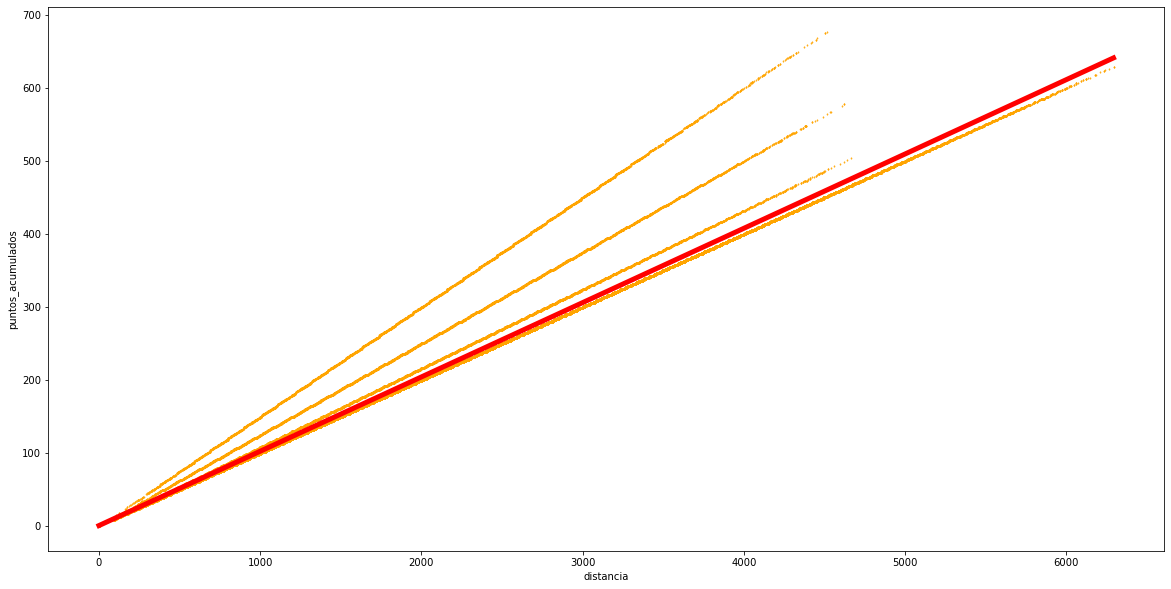

In [170]:
plt.figure(figsize=(20, 10))
sns.regplot(x = "distancia", 
            y = "puntos_acumulados", 
            data = df1, 
            marker = "d", 
            line_kws = {"color": "red", "linewidth": 5}, # cambiamos el color y el grosor de la linea de tendencia
            scatter_kws = {"color": "orange", "s": 1} # cambiamos el color y el tamaño de los puntos del scaterplot
            );

In [174]:
df['tarjeta_lealtad'].unique()

array(['Aurora', 'Nova', 'Star'], dtype=object)

<AxesSubplot:xlabel='distancia', ylabel='puntos_acumulados'>

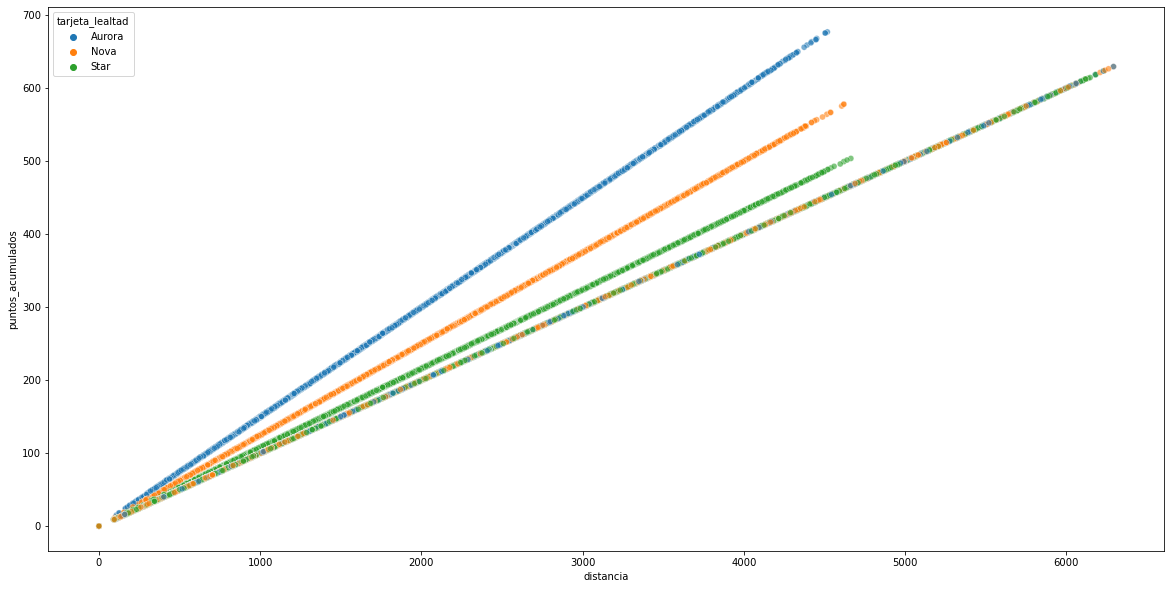

In [161]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = "distancia", 
                y = "puntos_acumulados", 
                data = df,
                hue = "tarjeta_lealtad",
                alpha=0.6)
                # size = 5, # cambia el tamaño
                # marker= "v", # cambia el tipo de marcador
                # color = "orange");